In [83]:
# -*- coding: utf-8 -*-
"""
% This function that you will implement is intended to behave like the built-in function 
% imfilter() in Matlab or equivalently the same function implemented as part of scipy.misc module
% in Python. You will implement imfilter from first principles, i.e., without using 
% any library functions. 

% See 'help imfilter' or 'help conv2'. While terms like "filtering" and
% "convolution" might be used interchangeably, we will essentially perform 2D correlation 
% between the filter and image. Referring to 'proj1_test_filtering.py' would help you with
% your implementation. 
  
% Your function should work for color images. Simply filter each color
% channel independently.

% Your function should work for filters of any width and height
% combination, as long as the width and height are odd (e.g. 1, 7, 9). This
% restriction makes it unambigious which pixel in the filter is the center
% pixel.

% Boundary handling can be tricky. The filter can't be centered on pixels
% at the image boundary without parts of the filter being out of bounds. If
% you look at 'help conv2' and 'help imfilter' in Matlab, you see that they have
% several options to deal with boundaries. You should simply recreate the
% default behavior of imfilter -- pad the input image with zeros, and
% return a filtered image which matches the input resolution. A better
% approach would be to mirror the image content over the boundaries for padding.

% % Uncomment if you want to simply call library imfilter so you can see the desired
% % behavior. When you write your actual solution, **you can't use imfilter,
% % correlate, convolve commands, but implement the same using matrix manipulations**. 
% % Simply loop over all the pixels and do the actual
% % computation. It might be slow.
"""


#from scipy.misc import imfilter
import numpy as np
""" Exemplar Gaussian 3x3 filter shown below-- see filters defined in proj1_test_filtering.py """
#filter = np.asarray([[0.1019,0.1154,0.1019],[0.1154,0.1308,0.1154],[0.1019,0.1154,0.1019]],\
#                    dtype=np.float32)

def my_imfilter_2d(image,filter):  #which will work identically to the function below
    max_r, max_c = len(filter)//2, len(filter[0])//2
    rows, col = len(image), len(image[0])
    output = np.zeros(image.shape, dtype = image.dtype)
    for i in range(rows):
        for j in range(col):
            for k in range(-max_r, max_r + 1):
                for l in range(-max_c, max_c + 1):
                    if i + k >= 0 and i + k < rows and j + l >= 0 and j + l < col:
                        output[i][j] += (image[i + k][j + l] * filter[k + max_r][l + max_c])
    return output

In [84]:
def my_imfilter(image, filter):
    if len(image.shape) == 2:
        return my_imfilter_2d(image, filter)
    r_cmp = my_imfilter_2d(image[:,:,0], filter)
    g_cmp = my_imfilter_2d(image[:,:,1], filter)
    b_cmp = my_imfilter_2d(image[:,:,2], filter)
    return np.dstack((r_cmp, g_cmp, b_cmp))

In [85]:
# import matplotlib.pyplot as plt
# img = plt.imread('einstein.bmp')
# filter = [[1,0,0],[0,1,0],[0,0,1]]
# img2 = my_imfilter(img, filter)
# plt.imshow(img2)
# plt.show()

In [86]:
# import scipy.ndimage

# r_cmp = scipy.ndimage.correlate(img[:,:,0], filter)
# g_cmp = scipy.ndimage.correlate(img[:,:,1], filter)
# b_cmp = scipy.ndimage.correlate(img[:,:,2], filter)
# img4 = np.dstack((r_cmp, g_cmp, b_cmp))
# plt.imshow(img4)
# plt.show()

In [87]:
def fspecial2d(shape, sigma):
    m,n = [(x-1.0)/2.0 for x in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp(-(x*x + y*y) / (2.0*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sum_ = h.sum()
    if sum_ != 0:
        h /= sum_
    return h

' adopted from code by James Hays (GATech)'

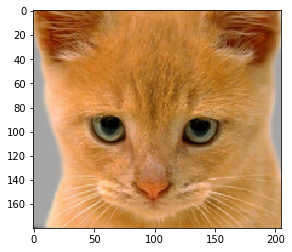

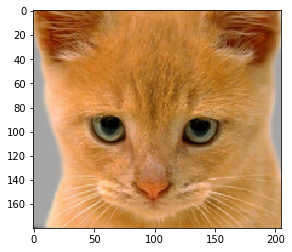

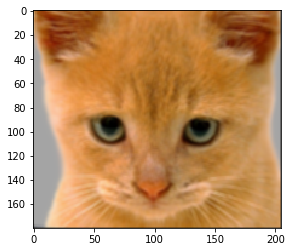

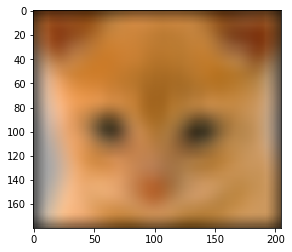

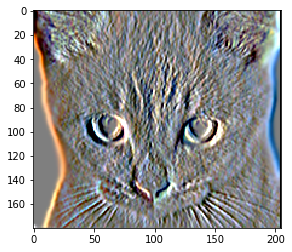

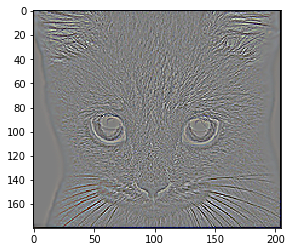

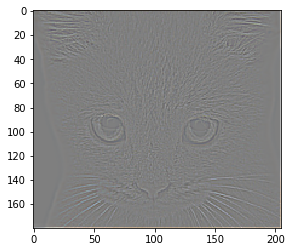

In [88]:
"""
% this script has test cases to help you test my_imfilter() which you will
% write. You should verify that you get reasonable output here before using
% your filtering to construct a hybrid image in proj1.m. The outputs are
% all saved and you can include them in your writeup. You can add calls to
% imfilter() if you want to check that my_imfilter() is doing something
% similar. """

import matplotlib.pyplot as plt
import os
# import cv2
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.transform import rescale, resize, downscale_local_mean

#%% close all figures
plt.close('all')

#%% Setup
test_image = mpimg.imread('../data/cat.bmp');
test_image = resize(test_image, (test_image.shape[0] // 2, test_image.shape[1] // 2), anti_aliasing=True)#resizing to speed up testing
plt.figure(1)
plt.imshow(test_image)


#%% This filter should do nothing regardless of the padding method you use.
""" Identity filter """

identity_filter = np.asarray([[0,0,0],[0,1,0],[0,0,0]]);
identity_image  = my_imfilter(test_image, identity_filter)

plt.figure(2)
plt.imshow(identity_image);
mpimg.imsave('../Results/identity_image.jpg',identity_image);
#

#%% This filter should remove some high frequencies
""" Small blur with a box filter """

blur_filter = np.asarray([[1,1,1],[1,1,1],[1,1,1]]);
blur_filter = blur_filter / np.sum(blur_filter); # making the filter sum to 1
#
blur_image = my_imfilter(test_image, blur_filter);
#
plt.figure(3) 
plt.imshow(blur_image);
mpimg.imsave('../Results/blur_image.jpg',blur_image);
#

#%% Large blur
""" This blur would be slow to do directly, so we instead use the fact that
     Gaussian blurs are separable and blur sequentially in each direction. """

large_1d_blur_filter = np.asarray([])# import values from fspecial('Gaussian', [25 1], 10) here
large_1d_blur_filter = np.asarray(fspecial2d([25, 1], 10))
large_blur_image = my_imfilter(test_image, large_1d_blur_filter);
large_blur_image = my_imfilter(large_blur_image, large_1d_blur_filter.T) #implement large_1d_blur_filter_transpose
#
plt.figure(4) 
plt.imshow(large_blur_image);
mpimg.imsave('../Results/large_blur_image.jpg', large_blur_image);
#
#% %If you want to see how slow this would be to do naively, try out this
#% %equivalent operation:
#% tic %tic and toc run a timer and then print the elapsted time
#% large_blur_filter = fspecial('Gaussian', [25 25], 10);
#% large_blur_image = my_imfilter(test_image, large_blur_filter);
#% toc 
#
#%% Oriented filter (Sobel Operator)
""" Edge Filter """
sobel_filter = np.asarray([[-1,0,1],[-2,0,2],[-1,0,1]]) #should respond to horizontal gradients
sobel_image = my_imfilter(test_image, sobel_filter);
#
# 0.5 added because the output image is centered around zero otherwise and mostly black
sobel_image = np.clip(sobel_image + 0.5, 0, 1)
plt.figure(5)
plt.imshow(sobel_image)
mpimg.imsave('../Results/sobel_image.jpg',sobel_image)
#
#
#%% High pass filter (Discrete Laplacian)
""" Laplacian Filter """
laplacian_filter = np.asarray([[0,1,0],[1,-4,1],[0,1,0]])
laplacian_image = my_imfilter(test_image, laplacian_filter)
# 0.5 added because the output image is centered around zero otherwise and mostly black
laplacian_image = np.clip(laplacian_image + 0.5, 0, 1)
plt.figure(6)
plt.imshow(laplacian_image)
mpimg.imsave('../Results/laplacian_image.jpg', laplacian_image)
#
#%% High pass "filter" alternative
""" High pass filter example we saw in class """
high_pass_image = test_image - blur_image #simply subtract the low frequency content
high_pass_image = np.clip(high_pass_image + 0.5, 0, 1)
plt.figure(7)
plt.imshow(high_pass_image);
mpimg.imsave('../Results/high_pass_image.jpg',high_pass_image)

""" adopted from code by James Hays (GATech)"""

In [89]:
import matplotlib.pyplot as plt
import os
#import cv2
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.transform import rescale, resize, downscale_local_mean

def vis_hybrid_image(hybrid_image):

  """
  %visualize a hybrid image by progressively downsampling the image and
  %concatenating all of the images together.
  """
  scales = 5#how many downsampled versions to create
  padding = 5 #how many pixels to pad.

  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] #counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2,scales+1):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype = np.float)), axis = 1) #implement the correct command here
      
      # dowsample image
      cur_image = resize(cur_image,(cur_image.shape[0] // 2, cur_image.shape[1] // 2), \
                    anti_aliasing=True)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height - cur_image.shape[0], cur_image.shape[1], num_colors), dtype = np.float), cur_image))
      output = np.concatenate((output, tmp), axis = 1)
  
  
  return output

""" adopted from code by James Hays (GATech)"""

' adopted from code by James Hays (GATech)'

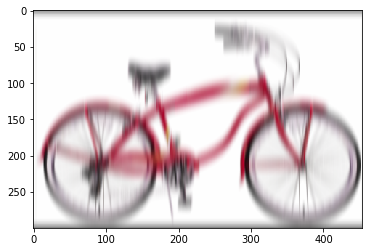

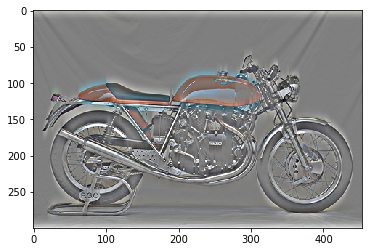

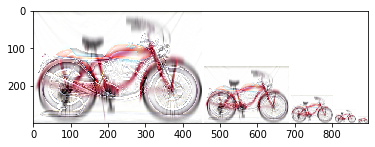

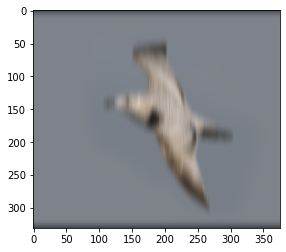

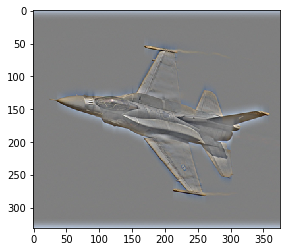

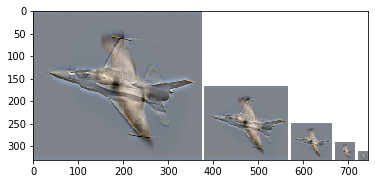

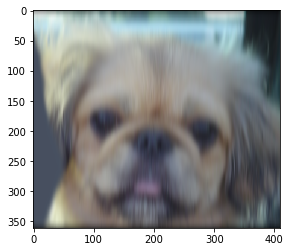

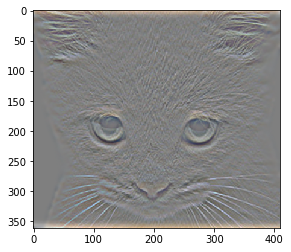

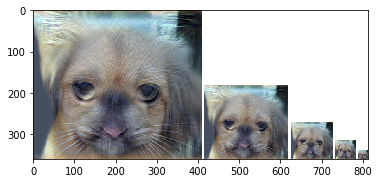

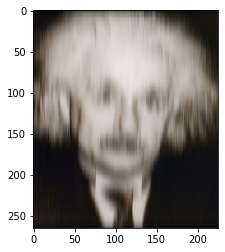

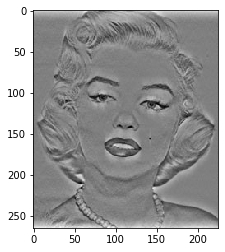

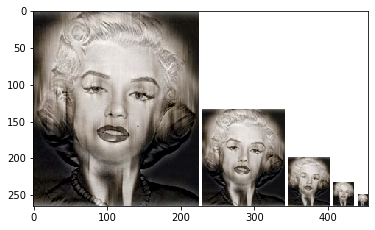

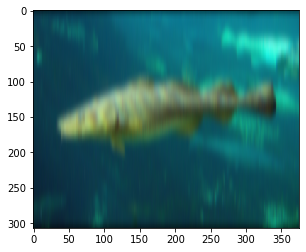

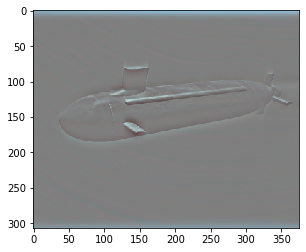

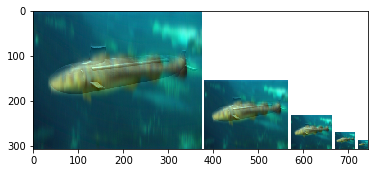

In [90]:
"""
% Before trying to construct hybrid images, it is suggested that you
% implement my_imfilter.m and then debug it using proj1_test_filtering.m

% Debugging tip: You can split your MATLAB code into cells using "%%"
% comments. The cell containing the cursor has a light yellow background,
% and you can press Ctrl+Enter to run just the code in that cell. This is
% useful when projects get more complex and slow to rerun from scratch
"""

import matplotlib.pyplot as plt
import os
#import cv2
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_float

#%% close all figures
plt.close('all') # closes all figures
image_pair = (('bicycle.bmp', 'motorcycle.bmp'), ('bird.bmp', 'plane.bmp'), ('dog.bmp', 'cat.bmp'), \
              ('einstein.bmp', 'marilyn.bmp'), ('fish.bmp', 'submarine.bmp'))

#%% Setup
#% read images and convert to floating point format
cnt = 1
for pair in image_pair:
    image1 = mpimg.imread('../data/' + pair[0])
    image1 = img_as_float(image1)
    image2 = mpimg.imread('../data/' + pair[1])
    image2 = img_as_float(image2)

    """
    % Several additional test cases are provided for you, but feel free to make
    % your own (you'll need to align the images in a photo editor such as
    % Photoshop). The hybrid images will differ depending on which image you
    % assign as image1 (which will provide the low frequencies) and which image
    % you asign as image2 (which will provide the high frequencies)
    """

    """ %% Filtering and Hybrid Image construction """
    cutoff_frequency = 7  

    """This is the standard deviation, in pixels, of the 
    % Gaussian blur that will remove the high frequencies from one image and 
    % remove the low frequencies from another image (by subtracting a blurred
    % version from the original version). You will want to tune this for every
    % image pair to get the best results. """

    filter = fspecial2d((cutoff_frequency*4 + 1, 1), cutoff_frequency)
    """
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % YOUR CODE BELOW. Use my_imfilter to create 'low_frequencies' and
    % 'high_frequencies' and then combine them to create 'hybrid_image'
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % Remove the high frequencies from image1 by blurring it. The amount of
    % blur that works best will vary with different image pairs
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
    """

    low_frequencies = my_imfilter(image1, filter)

    """
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % Remove the low frequencies from image2. The easiest way to do this is to
    % subtract a blurred version of image2 from the original version of image2.
    % This will give you an image centered at zero with negative values.
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    """

    high_frequencies = image2 - my_imfilter(image2, filter)

    """
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % Combine the high frequencies and low frequencies
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    """
    hybrid_image = low_frequencies + high_frequencies
    hybrid_image = np.clip(hybrid_image, 0, 1)
    #%% Visualize and save outputs
    high_frequencies = np.clip(high_frequencies + 0.5, 0, 1)
    plt.figure(cnt)
    plt.imshow(low_frequencies)
    plt.figure(cnt + 1)
    plt.imshow(high_frequencies);
    vis = vis_hybrid_image(hybrid_image) #see function script vis_hybrid_image.py
    plt.figure(cnt + 2)
    plt.imshow(vis)
    mpimg.imsave('../Results/low_frequencies_' + pair[0],low_frequencies)
    mpimg.imsave('../Results/high_frequencies_' + pair[0],high_frequencies)
    mpimg.imsave('../Results/hybrid_image_' + pair[0],hybrid_image)
    mpimg.imsave('../Results/hybrid_image_scales_' + pair[0],vis)
    cnt += 3